In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers

#import warnings
#warnings.filterwarnings('ignore')

In [66]:
df = pd.read_csv('auto-mpg.csv')
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [67]:
df.shape

(398, 9)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [69]:
df.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [70]:
df['horsepower'].unique()

array(['130', '165', '150', '140', '198', '220', '215', '225', '190',
       '170', '160', '95', '97', '85', '88', '46', '87', '90', '113',
       '200', '210', '193', '?', '100', '105', '175', '153', '180', '110',
       '72', '86', '70', '76', '65', '69', '60', '80', '54', '208', '155',
       '112', '92', '145', '137', '158', '167', '94', '107', '230', '49',
       '75', '91', '122', '67', '83', '78', '52', '61', '93', '148',
       '129', '96', '71', '98', '115', '53', '81', '79', '120', '152',
       '102', '108', '68', '58', '149', '89', '63', '48', '66', '139',
       '103', '125', '133', '138', '135', '142', '77', '62', '132', '84',
       '64', '74', '116', '82'], dtype=object)

In [71]:
print(df.shape)
df = df[df['horsepower'] != '?']
print(df.shape)

(398, 9)
(392, 9)


In [72]:
df['horsepower'] = df['horsepower'].astype(int)
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [73]:
df.nunique()

mpg             127
cylinders         5
displacement     81
horsepower       93
weight          346
acceleration     95
model year       13
origin            3
car name        301
dtype: int64

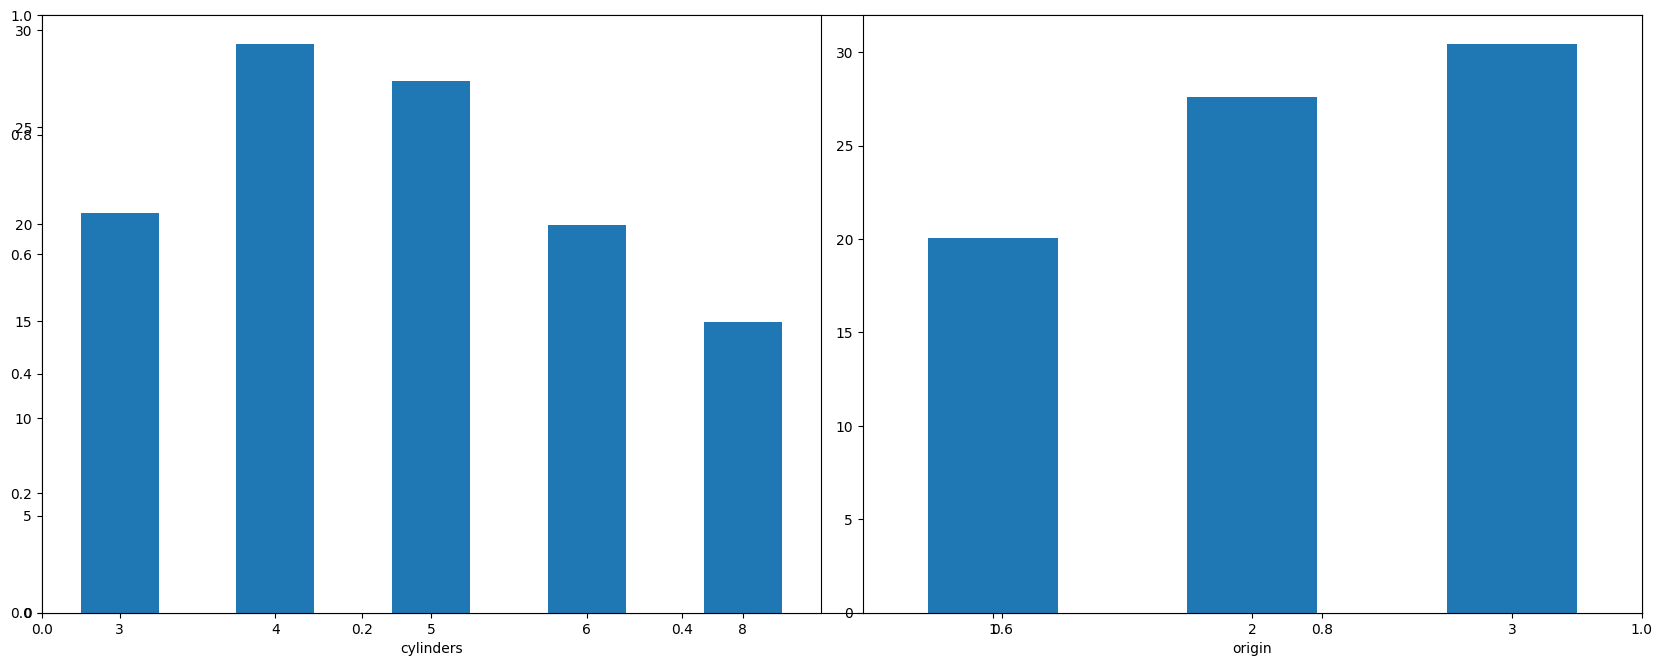

In [74]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.subplots(figsize=(17, 7))
for i, col in enumerate(['cylinders', 'origin']):
    plt.subplot(1, 2, i+1)
    x = numeric_df.groupby(col).mean()['mpg']
    x.plot.bar()
    plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

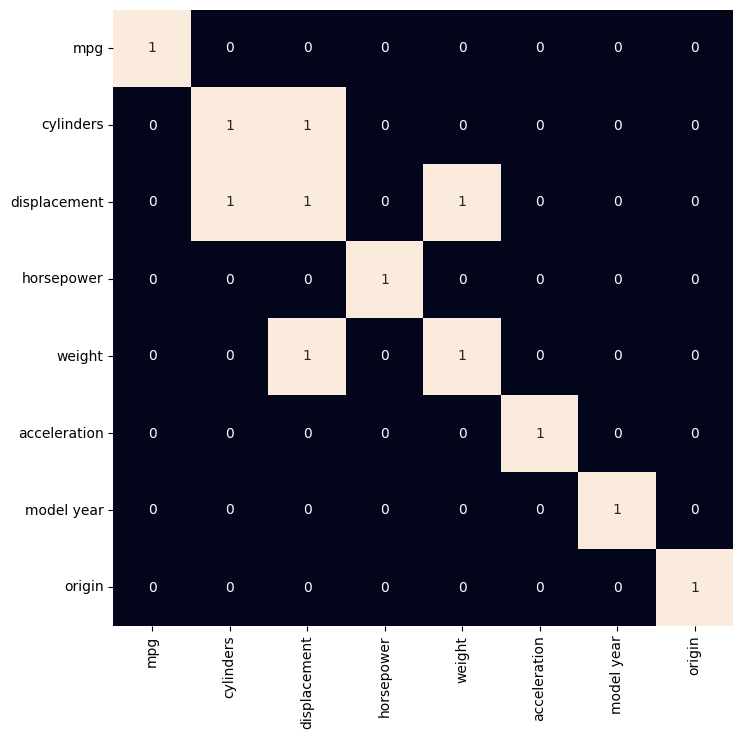

In [75]:
plt.figure(figsize=(8, 8)) 
sns.heatmap(numeric_df.corr()> 0.9, 
        annot=True, 
        cbar=False) 
plt.show()



In [76]:
df.drop('displacement',
		axis=1,
		inplace=True)

In [77]:
from sklearn.model_selection import train_test_split
features = df.drop(['mpg', 'car name'], axis=1)
target = df['mpg'].values

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
									test_size=0.2,
									random_state=22)
X_train.shape, X_val.shape

((313, 6), (79, 6))

In [78]:
# Data Input Pipeline

AUTO = tf.data.experimental.AUTOTUNE	# automatically tune the process

train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train)) # create a adatset
	.batch(32) # batch size no 32
	.prefetch(AUTO) # automatically tune prefetching
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.batch(32)
	.prefetch(AUTO)
)

In [86]:
# Model Architecture
# Define a neural network using TensorFlow's Keras Sequential API

# Initialize the Sequential model
model = keras.Sequential([

    # First Dense layer with 256 neurons, ReLU activation, and input shape of 6 features
    layers.Dense(256, activation='relu', input_shape=[6]),  
    
    # Apply Batch Normalization, norma;ize inputs in each layer to stabilize training
    layers.BatchNormalization(),
    
    # Second Dense layer with 256 neurons and ReLU activation
    layers.Dense(256, activation='relu'),
    
    # Dropout layer, 30% of neurons are dropped set to 0 to prevent overfitting
    # Improve generalization on unseen data.
    layers.Dropout(0.3),
    
    # Apply another Batch Normalization after the second Dense layer
    layers.BatchNormalization(),
    
    # Output Dense layer with 1 neuron and ReLU activation
    # ReLU here ensures the output is non-negative
    layers.Dense(1, activation='relu')  
])


In [80]:
model.compile(
	loss='mae',
	optimizer='adam',
	metrics=['mape']
)

In [81]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,889 (273.00 KB)

 Trainable params: 68,865 (269.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [82]:
history = model.fit(train_ds,
					epochs=50,
					validation_data=val_ds)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 21.8958 - mape: 88.7273 - val_loss: 34.7869 - val_mape: 212.7369
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 19.9172 - mape: 76.4400 - val_loss: 19.1875 - val_mape: 115.2312
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.3131 - mape: 73.2266 - val_loss: 13.2347 - val_mape: 70.3198
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.8524 - mape: 71.2530 - val_loss: 11.4817 - val_mape: 54.2023
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 18.0933 - mape: 67.1654 - val_loss: 10.5742 - val_mape: 47.1621
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.4900 - mape: 64.3777 - val_loss: 10.0790 - val_mape: 45.4559
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 17.1614 - mape: 63.2244 - val_loss: 9.3631 - val_mape: 39.4465
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16.4373 - mape: 59.6248 - val_loss: 8.4706 - val_mape: 36.2273
Epoch 9/50
10/10 ━━━━━━

In [83]:
history_df = pd.DataFrame(history.history)
history_df.head()

,loss,mape,val_loss,val_mape
0,21.114553,83.866730,34.786900,212.736893
1,19.737278,75.743134,19.187466,115.231201
2,19.117662,72.656082,13.234656,70.319801
3,18.621576,70.470161,11.481731,54.202271
4,17.882011,66.642563,10.574184,47.162071


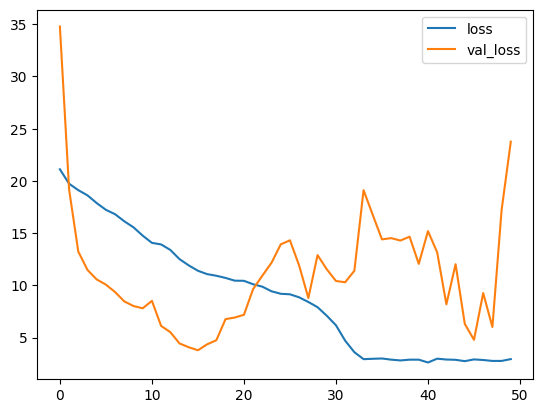

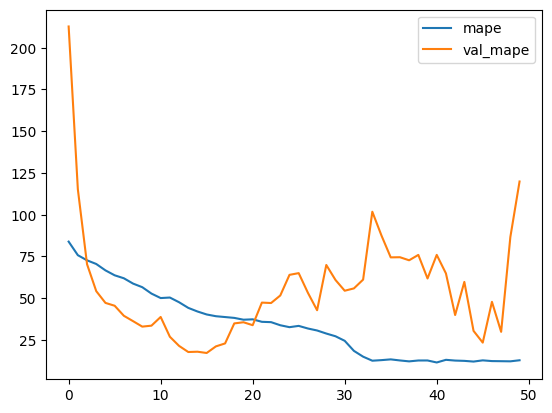

In [84]:
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['mape', 'val_mape']].plot()
plt.show()